# カフェのサービス評価実験 - 分析

## ライブラリとデータの挿入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
original = pd.read_csv('data.csv', header=0)

---
## 定量的分析（チップ）

### 正規性の検定（Shapiro-Wilk検定）

正規性の検定の1つで、データが正規分布しているかを判断するために用いる。  
参照：https://www.study-channel.com/2015/07/shapiro-wilk-test.html

In [3]:
from scipy.stats import shapiro

aov_data = original.iloc[:, 24:]

W, p_shapiro = shapiro(aov_data['金額'])
print('W = %f, p-value = %f'%(W, p_shapiro))

W = 0.892557, p-value = 0.035751


### マン=ホイットニーのU検定

ノンパラメトリック検定の1つで、対応のないデータにおいて**2つのグループ間**に差があるかないかについての検定のこと。単に $U$ 検定とも言われる。ウィルコクソンの順位和検定と同等の結論が得られる。  
参照：https://bellcurve.jp/statistics/glossary/575.html

$Cohen's\ d$ はパラメトリックな効果量なので、ノンパラメトリック検定では効果量として $r$ が使われるそう。  
効果量 $r$ は、検定統計量を $Z$ 変換した値とサンプルサイズ $N$ を用いて、
$$
r = \frac{Z}{\sqrt N}
$$
で求められる。なお、検定統計量 $U$ は標本サイズ $n_1, n_2$ が大きくなるにつれ、次のような平均 $E$、分散 $V$ の正規分布に近づく。
$$
E = \frac{n_1 n_2}{2}, \quad V = \frac{n_1 n_2 (n_1+n_2+1)}{12}
$$
したがって、検定統計量 $U$ は、平均 0、分散 1 の標準正規分布に従う統計量 $Z$ に変換できる。
$$
Z = \frac{|U - E|}{\sqrt V}
$$
効果量 $r$ の判定基準は以下の表の通り。

<table>
  <thead>
    <tr>
      <th rowspan="2">指標</th>
      <th colspan="3">効果量の基準</th>
    </tr>
    <tr>
      <th>小</th>
      <th>中</th>
      <th>大</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><math><mi>r</mi></math></td>
      <td>0.1</td>
      <td>0.3</td>
      <td>0.5</td>
    </tr>
  </tbody>
</table>

【参照】
- https://www.jspt.or.jp/ebpt_glossary/effect-size.html
- https://biolab.sakura.ne.jp/steel-dwass.html

In [4]:
def effectsize_mannwhitneyu(x1, x2, U):
    n1, n2 = len(x1), len(x2)
    E_U = n1 * n2 / 2
    V_U = n1 * n2 * (n1+n2+1) / 12
    Z = abs(U - E_U) / np.sqrt(V_U)
    r = Z / np.sqrt(n1+n2)
    return r

In [5]:
from scipy.stats import mannwhitneyu

human = aov_data[aov_data['店員'] == '人']
robot = aov_data[aov_data['店員'] == 'ロボット']

U, p_mannwhitneyu = mannwhitneyu(human['金額'], robot['金額'])
r = effectsize_mannwhitneyu(human['金額'], robot['金額'], U)
print('U = %f, p-value = %f, r = %f'%(U, p_mannwhitneyu, r))

U = 53.500000, p-value = 0.509893, r = 0.159220


### （クラスカル=ウォリス検定）

順位を用いたノンパラメトリック検定の1つで、対応のない**3つ以上のグループ間**の差の有無を調べたいときに用いられる。$H$ 検定とも言う。  
参照：https://bellcurve.jp/statistics/glossary/1252.html

本研究では用いないが、一応求めると以下の通り。

In [6]:
from scipy.stats import kruskal

H, p_kruskal = kruskal(human['金額'], robot['金額'])
print('H = %f, p-value = %f'%(H, p_kruskal))

H = 0.490268, p-value = 0.483808


### 棒グラフ

In [7]:
df_bar = pd.DataFrame({
    '人': human.reset_index()['金額'],
    'ロボット': robot.reset_index()['金額']
})
df_bar.apply(lambda s: s.apply(lambda x: format(x, 'g')))

,人,ロボット
0,250,220
1,350,110
2,110,150
3,250,100
4,200,250
5,200,100
6,240,250
7,140,210
8,110,100
9,nan,350


In [8]:
df_bar.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))).transpose()

,count,mean,std,min,25%,50%,75%,max
人,9,205.556,77.9601,110,140,200,250,350
ロボット,10,184,85.6608,100,102.5,180,242.5,350


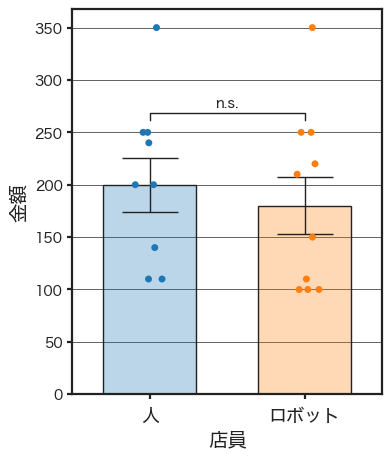

In [9]:
# グラフの初期設定
fore_color = '#222222'  # 黒色の指定
plt.rcParams['font.family'] = 'Hiragino sans'  # フォント
fig = plt.figure(figsize=(4, 5))
ax = fig.add_subplot(1, 1, 1)  # サブプロットの追加（行数，列数，番号）
plt.setp(ax.spines.values(), linewidth=1.6, color=fore_color)  # 枠の設定
ax.tick_params(axis='x', width=1.6, colors=fore_color, direction='out')  # x軸の目盛設定
ax.tick_params(axis='y', width=1.6, colors=fore_color, direction='out')  # y軸の目盛設定
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color=fore_color)  # 横線のグリッド設定
ax.set_axisbelow(True)  # グリッドを背面に表示

# 棒グラフ＆エラーバー（標準誤差）
x_position = np.arange(len(df_bar.columns))
height = df_bar.median()
yerr = df_bar.std() / np.sqrt(df_bar.count())  # 標準誤差
error_bar_set = dict(lw=1, capthick=1, capsize=20)
ax.bar(
    x_position, height,
    yerr=yerr, error_kw=error_bar_set, ecolor=fore_color,
    tick_label=df_bar.columns, color=[(0.12, 0.47, 0.71, 0.3), (1.00, 0.5, 0.05, 0.3)], width=0.6,
    edgecolor=fore_color, linewidth=1.0
)

# 有意差の描画
from barplot_annotate_bracket import barplot_annotate_bracket
barplot_annotate_bracket(
    0, 1, p_mannwhitneyu,
    x_position, height, yerr=yerr, ax=ax,
    dh=0.15, barh=0.03,
    color=fore_color, linewidth=1.0
)

# jitter plot
np.random.seed(350)  # jitter plotを固定
df_melt = pd.melt(df_bar)
sns.stripplot(data=df_melt, x='variable', y='value', hue='variable', jitter=True, legend=False, ax=ax)

# 目盛ラベルの設定
ax.tick_params(axis='x', pad=6)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13, color=fore_color)

# 軸ラベルの設定
ax.set_xlabel('店員', fontsize=14, color=fore_color)
ax.set_ylabel('金額', fontsize=14, color=fore_color)

# 表示
plt.show()

# 画像として出力
fig.savefig('./barplot.png', dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

各条件におけるチップの金額の中央値。エラーバーは**標準誤差**。

【参考】
- 棒グラフの上にjitter plotを重ねて描く：https://stats.biopapyrus.jp/python/barplot.html
- 棒グラフ間の有意差の描画：https://omedstu.jimdofree.com/2019/02/11/matplotlibで棒グラフ間の有意差の描画をする/

---
## 定性的分析（SERVQUAL）

### アンケート項目

<table>
  <thead>
    <tr>
      <th>次元</th>
      <th colspan="2">項目</th>
      <th>逆転項目</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td align="center" style="background-color: rgba(31,119,180,0.1);">有形性</td>
      <td>Q1</td>
      <td>最新の設備を整えている</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(31,119,180,0.1);">有形性</td>
      <td>Q2</td>
      <td>施設の見た目は立派である</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(31,119,180,0.1);">有形性</td>
      <td>Q3</td>
      <td>スタッフの身なりがきちんとしている</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(31,119,180,0.1);">有形性</td>
      <td>Q4</td>
      <td>施設の外観は、提供されるサービスの種類と一致している</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(255,127,14,0.1);">信頼性</td>
      <td>Q5</td>
      <td>約束を守る</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(255,127,14,0.1);">信頼性</td>
      <td>Q6</td>
      <td>お客様が問題を抱えているときに、誠実に対応してくれる</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(255,127,14,0.1);">信頼性</td>
      <td>Q7</td>
      <td>頼りになる</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(255,127,14,0.1);">信頼性</td>
      <td>Q8</td>
      <td>時間通りにサービスを提供してくれる</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(255,127,14,0.1);">信頼性</td>
      <td>Q9</td>
      <td>正確に記録を管理している</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(44,160,44,0.1);">応答性</td>
      <td>Q10</td>
      <td>いつサービスが提供されるか正確に伝わっている</td>
      <td align="center">○</td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(44,160,44,0.1);">応答性</td>
      <td>Q11</td>
      <td>迅速なサービスが期待できる</td>
      <td align="center">○</td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(44,160,44,0.1);">応答性</td>
      <td>Q12</td>
      <td>いつも進んでお客様に力を貸そうとする</td>
      <td align="center">○</td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(44,160,44,0.1);">応答性</td>
      <td>Q13</td>
      <td>忙しくてもお客様の要望に迅速に対応してくれる</td>
      <td align="center">○</td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(214,39,40,0.1);">保証性</td>
      <td>Q14</td>
      <td>スタッフを信頼できる</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(214,39,40,0.1);">保証性</td>
      <td>Q15</td>
      <td>スタッフと安心して接することができる</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(214,39,40,0.1);">保証性</td>
      <td>Q16</td>
      <td>スタッフは礼儀正しい</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(214,39,40,0.1);">保証性</td>
      <td>Q17</td>
      <td>スタッフはお客様の質問に答えられるだけの十分な知識を持っている</td>
      <td align="center"></td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(148,103,189,0.1);">共感性</td>
      <td>Q18</td>
      <td>お客様一人ひとりの要望に合わせて対応している</td>
      <td align="center">○</td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(148,103,189,0.1);">共感性</td>
      <td>Q19</td>
      <td>スタッフは個人的な要望をくみ取ってくれる</td>
      <td align="center">○</td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(148,103,189,0.1);">共感性</td>
      <td>Q20</td>
      <td>スタッフはお客様が何を必要としているかが分かっている</td>
      <td align="center">○</td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(148,103,189,0.1);">共感性</td>
      <td>Q21</td>
      <td>お客様の一番関心のあることを気にかけてくれる</td>
      <td align="center">○</td>
    </tr>
    <tr>
      <td align="center" style="background-color: rgba(148,103,189,0.1);">共感性</td>
      <td>Q22</td>
      <td>営業時間は便利である</td>
      <td align="center">○</td>
    </tr>
  </tbody>
</table>

####  数値変換

In [10]:
def convert2int(df: pd.DataFrame) -> pd.DataFrame:
    for i, col in enumerate(df.columns):
        if 'ない' in col:
            df[col] = df[col].str.replace('強くそう思う', '1')
            df[col] = df[col].str.replace('ややそう思う', '3')
            df[col] = df[col].str.replace('そう思う', '2')
            df[col] = df[col].str.replace('どちらともいえない', '4')
            df[col] = df[col].str.replace('ややそう思わない', '5')
            df[col] = df[col].str.replace('全くそう思わない', '7')
            df[col] = df[col].str.replace('そう思わない', '6')
        else:
            df[col] = df[col].str.replace('強くそう思う', '7')
            df[col] = df[col].str.replace('ややそう思う', '5')
            df[col] = df[col].str.replace('そう思う', '6')
            df[col] = df[col].str.replace('どちらともいえない', '4')
            df[col] = df[col].str.replace('ややそう思わない', '3')
            df[col] = df[col].str.replace('全くそう思わない', '1')
            df[col] = df[col].str.replace('そう思わない', '2')

        new_col = 'Q' + str(i+1)
        df = df.rename({str(col): new_col}, axis='columns')
        df[new_col] = df[new_col].astype(int)

    return df

In [11]:
fa_data = original.iloc[:, 2:24]
human = original[original['店員'] == '人']
fa_data_human = human.iloc[:, 2:24]
robot = original[original['店員'] == 'ロボット']
fa_data_robot = robot.iloc[:, 2:24]

In [12]:
fa_data = convert2int(fa_data)
fa_data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22
count,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
mean,5,4.21053,5.68421,4.10526,5.73684,4.63158,4.31579,6.05263,5.26316,3,...,4.31579,4.73684,4.52632,6.21053,5.05263,4.10526,4.15789,4.78947,4,4.15789
std,1.85592,1.54844,1.66842,1.79179,1.24017,1.97795,1.73374,1.17727,1.408,1.69967,...,1.94515,1.6945,2.1697,1.18223,1.74718,1.82254,2.03479,2.04339,1.97203,1.06787
min,1,2,1,1,2,1,1,2,3,1,...,1,1,1,2,2,1,1,1,1,2
25%,4,3,5,3,5,3,3.5,6,4,2,...,3,4,2.5,6,3.5,3,2,3,2.5,4
50%,6,4,6,4,6,5,5,6,6,3,...,5,5,5,6,6,4,5,6,5,4
75%,6,5.5,7,5.5,6.5,6,5,7,6,3.5,...,6,6,6,7,6,5.5,6,6,5,4.5
max,7,7,7,7,7,7,7,7,7,6,...,7,7,7,7,7,7,7,7,7,6


In [13]:
fa_data_human = convert2int(fa_data_human)
fa_data_human.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22
count,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
mean,3.66667,4.44444,6.55556,4.33333,5.55556,5.55556,5.11111,6,4.88889,2.88889,...,5.33333,5,5.22222,6.66667,5,4,4.88889,4.55556,4.33333,4.11111
std,1.80278,1.81046,0.726483,2,1.66667,1.74005,1.16667,1.58114,1.53659,2.02759,...,1.87083,1.80278,1.56347,0.5,1.80278,2.17945,1.90029,2.12786,2,1.2693
min,1,2,5,1,2,3,3,2,3,1,...,1,2,2,6,2,1,2,1,1,2
25%,2,3,6,3,5,4,5,6,4,1,...,5,5,5,6,4,3,4,3,3,4
50%,4,5,7,5,6,6,5,6,5,2,...,6,6,5,7,6,3,5,6,5,4
75%,5,6,7,6,7,7,6,7,6,4,...,6,6,6,7,6,6,6,6,6,4
max,6,7,7,7,7,7,7,7,7,6,...,7,7,7,7,7,7,7,7,7,6


In [14]:
fa_data_robot = convert2int(fa_data_robot)
fa_data_robot.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22
count,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
mean,6.2,4,4.9,3.9,5.9,3.8,3.6,6.1,5.6,3.1,...,3.4,4.5,3.9,5.8,5.1,4.2,3.5,5,3.7,4.2
std,0.788811,1.33333,1.91195,1.66333,0.737865,1.8738,1.89737,0.737865,1.26491,1.44914,...,1.57762,1.64992,2.5144,1.47573,1.79196,1.54919,2.01384,2.0548,2.00278,0.918937
min,5,2,1,1,5,1,1,5,3,1,...,1,1,1,2,2,2,1,1,1,3
25%,6,3,5,3,5.25,2.25,2,6,5.25,2.25,...,2.25,3.5,1.25,6,3.5,3,2,3.5,2.25,4
50%,6,4,5.5,4,6,3.5,4.5,6,6,3,...,3,5,4.5,6,6,5,2.5,5.5,4,4
75%,7,4.75,6,4,6,5.75,5,6.75,6,3,...,4.75,5.75,6,6.75,6,5,5.75,6.75,5,4.75
max,7,6,7,7,7,6,6,7,7,6,...,6,6,7,7,7,6,6,7,7,6


### SERVQUAL各下位尺度得点の店員による比較

In [15]:
# 次元
dimensions = {
    '有形性': ['Q1', 'Q2', 'Q3', 'Q4'],
    '信頼性': ['Q5', 'Q6', 'Q7', 'Q8', 'Q9'],
    '応答性': ['Q10', 'Q11', 'Q12', 'Q13'],
    '保証性': ['Q14', 'Q15', 'Q16', 'Q17'],
    '共感性': ['Q18', 'Q19', 'Q20', 'Q21', 'Q22']
}

#### 正規性の検定（Shapiro-Wilk検定）

In [16]:
from scipy.stats import shapiro

for dim in dimensions.keys():
    df_vertical = pd.melt(fa_data.loc[:, dimensions[dim]])
    W, p_shapiro = shapiro(df_vertical['value'])
    print('[%s] W = %f, p-value = %f'%(dim, W, p_shapiro))

[有形性] W = 0.909584, p-value = 0.000049
[信頼性] W = 0.867787, p-value = 0.000000
[応答性] W = 0.906716, p-value = 0.000037
[保証性] W = 0.829849, p-value = 0.000000
[共感性] W = 0.931770, p-value = 0.000096


#### マン=ホイットニーのU検定

In [17]:
df_res = pd.DataFrame({
    'median-human': 0.0, 'median-robot': 0.0,
    '1st Qu.-human': 0.0, '1st Qu.-robot': 0.0,
    '3rd Qu.-human': 0.0, '3rd Qu.-robot': 0.0,
    'U': 0.0, 'p-value': 0.0, 'r': 0.0
}, index=dimensions)

for dim in dimensions.keys():
    human_vertical = pd.melt(fa_data_human.loc[:, dimensions[dim]])
    df_res.loc[dim, 'median-human'] = human_vertical['value'].median()
    df_res.loc[dim, '1st Qu.-human'] = human_vertical['value'].quantile(0.25)
    df_res.loc[dim, '3rd Qu.-human'] = human_vertical['value'].quantile(0.75)

    robot_vertical = pd.melt(fa_data_robot.loc[:, dimensions[dim]])
    df_res.loc[dim, 'median-robot'] = robot_vertical['value'].median()
    df_res.loc[dim, '1st Qu.-robot'] = robot_vertical['value'].quantile(0.25)
    df_res.loc[dim, '3rd Qu.-robot'] = robot_vertical['value'].quantile(0.75)

    U, p_mannwhitneyu = mannwhitneyu(human_vertical['value'], robot_vertical['value'])
    r = effectsize_mannwhitneyu(human_vertical['value'], robot_vertical['value'], U)
    df_res.loc[dim, 'U'] = U
    df_res.loc[dim, 'p-value'] = p_mannwhitneyu
    df_res.loc[dim, 'r'] = r

df_res.apply(lambda s: s.apply(lambda x: format(x, '.3f')))

,median-human,median-robot,1st Qu.-human,1st Qu.-robot,3rd Qu.-human,3rd Qu.-robot,U,p-value,r
有形性,5.000,5.000,3.000,3.750,6.000,6.000,736.000,0.870,0.019
信頼性,6.000,6.000,4.000,4.250,7.000,6.000,1292.500,0.201,0.128
応答性,6.000,3.000,3.750,2.000,6.000,5.000,1053.000,0.000,0.397
保証性,6.000,6.000,5.000,3.000,7.000,6.000,861.500,0.129,0.169
共感性,4.000,4.500,3.000,3.000,6.000,5.000,1222.500,0.464,0.075


### レーダーチャート

#### レーダーチャート用データ

In [18]:
df_radar = pd.DataFrame({'人': df_res['median-human'], 'ロボット': df_res['median-robot']})
df_radar.apply(lambda s: s.apply(lambda x: format(x, 'g')))

,人,ロボット
有形性,5,5
信頼性,6,6
応答性,6,3
保証性,6,6
共感性,4,4.5


In [19]:
angles_human = np.linspace(start=0, stop=2*np.pi, num=len(df_radar['人'])+1, endpoint=True)
values_human = np.concatenate((df_radar['人'], [df_radar['人'].iloc[0]]))
angles_robot = np.linspace(start=0, stop=2*np.pi, num=len(df_radar['ロボット'])+1, endpoint=True)
values_robot = np.concatenate((df_radar['ロボット'], [df_radar['ロボット'].iloc[0]]))

#### プロット

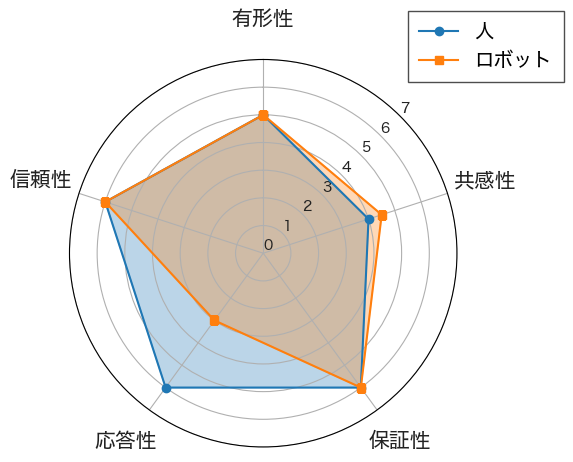

In [20]:
# グラフの初期設定
fore_color = '#222222'  # 黒色の指定
plt.rcParams['font.family'] = 'Hiragino sans'  # フォント
fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot(1, 1, 1, projection='polar')  # サブプロットの追加（行数，列数，番号，極座標を指定）

# データのプロット
ax.plot(angles_human, values_human, 'o-', color='tab:blue', label='人')
ax.fill(angles_human, values_human, alpha=0.3, color='tab:blue')
ax.plot(angles_robot, values_robot, 's-', color='tab:orange', label='ロボット')
ax.fill(angles_robot, values_robot, alpha=0.3, color='tab:orange')

# 表示範囲設定
ax.set_rlim(0, 7)

# 目盛ラベルの設定
ax.set_rgrids(list(range(8)), angle=315, fontsize=10, color=fore_color)

# ラベルの設定・回転座標の設定
ax.set_thetagrids(angles_human[:-1]*180/np.pi, df_radar.index, fontsize=15, color=fore_color)
ax.set_theta_zero_location('N')  # 北向き
ax.tick_params(pad=18)

# 凡例の設定
ax.legend(
    loc='upper right', bbox_to_anchor=(1.3, 1.15),
    fontsize=14, edgecolor=fore_color, borderpad=0.6, fancybox=False
)

# 表示
plt.show()

# 画像として出力
fig.savefig('./radar_chart.png', dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

各次元におけるSERVQUALの得点の中央値。

### 確認的因子分析

【参考】

- https://note.com/k_fukunaka/n/ncf493169157a
- https://www.business-research-lab.com/220817-3/

In [21]:
import semopy

mod = """
    D1 =~ Q1 + Q2 + Q3 + Q4
    D2 =~ Q5 + Q6 + Q7 + Q8 + Q9
    D3 =~ Q10 + Q11 + Q12 + Q13
    D4 =~ Q14 + Q15 + Q16 + Q17
    D5 =~ Q18 + Q19 + Q20 + Q21 + Q22
"""

# 確認的因子分析の実行
model = semopy.Model(mod)
result = model.fit(fa_data)

# 標準解を含む結果の出力
inspect = model.inspect(std_est=True)
inspect

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,Q1,~,D1,1.000000,0.248877,-,-,-
1,Q2,~,D1,2.515560,0.750547,2.302651,1.092463,0.27463
2,Q3,~,D1,0.111188,0.030790,0.834003,0.133318,0.893942
3,Q4,~,D1,3.878355,1.000000,3.607519,1.075076,0.282341
4,Q5,~,D2,1.000000,1.000000,-,-,-
5,Q6,~,D2,0.042395,0.026597,0.365981,0.115839,0.90778
6,Q7,~,D2,0.056305,0.040283,0.321255,0.175265,0.860872
7,Q8,~,D2,0.587020,0.618444,0.298286,1.967977,0.049071
8,Q9,~,D2,0.299270,0.263575,0.280451,1.067103,0.285925
9,Q10,~,D3,1.000000,0.435062,-,-,-


In [22]:
# 適合度の出力
stats = semopy.calc_stats(model)
stats.transpose()

,Value
DoF,199.000000
DoF Baseline,231.000000
chi2,503.286155
chi2 p-value,0.000000
chi2 Baseline,643.713659
CFI,0.262718
GFI,0.218152
AGFI,0.092428
NFI,0.218152
TLI,0.144161


In [23]:
# 推定後のパス係数付きパス図の出力
plot_sem = semopy.semplot(model, './model_est.png', plot_covs=True, std_ests=True)

![](./model_est.png)

### 探索的因子分析

#### 標準化

In [24]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(fa_data)
z = sc.transform(fa_data)

sc = StandardScaler()
sc.fit(fa_data_human)
z_human = sc.transform(fa_data_human)

sc = StandardScaler()
sc.fit(fa_data_robot)
z_robot = sc.transform(fa_data_robot)

#### 主成分分析

In [25]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(z)

PCA()

In [26]:
pca_human = PCA()
pca_human.fit(z_human)

PCA()

In [27]:
pca_robot = PCA()
pca_robot.fit(z_robot)

PCA()

#### 因子数の決定

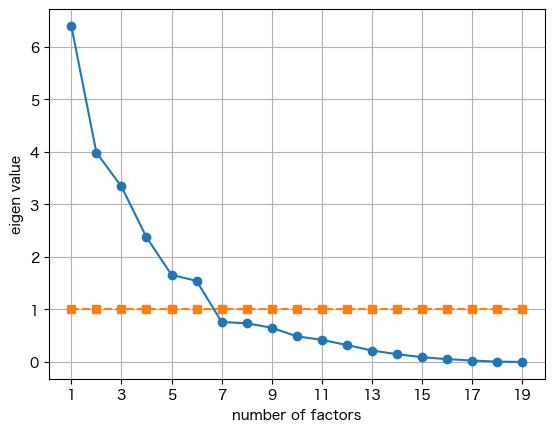

In [28]:
ev = pca.explained_variance_
ev_1 = np.ones(len(ev))

plt.plot(ev, 'o-', zorder=3)
plt.plot(ev_1, 's--', zorder=2)

plt.xlabel('number of factors')
plt.ylabel('eigen value')

xticks = np.array(range(0, len(ev), 2))
plt.xticks(xticks, xticks + 1)

plt.grid()
plt.show()

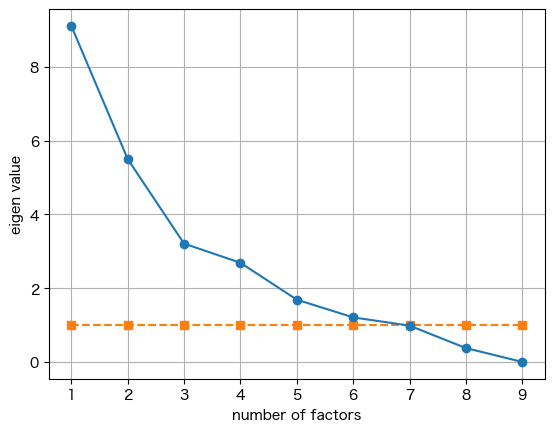

In [29]:
ev = pca_human.explained_variance_
ev_1 = np.ones(len(ev))

plt.plot(ev, 'o-', zorder=3)
plt.plot(ev_1, 's--', zorder=2)

plt.xlabel('number of factors')
plt.ylabel('eigen value')

xticks = np.array(range(0, len(ev)))
plt.xticks(xticks, xticks + 1)

plt.grid()
plt.show()

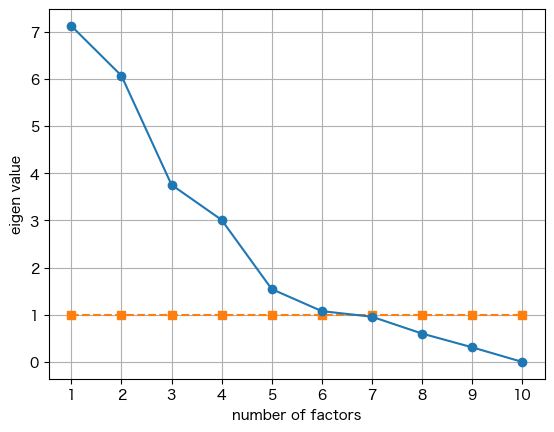

In [30]:
ev = pca_robot.explained_variance_
ev_1 = np.ones(len(ev))

plt.plot(ev, 'o-', zorder=3)
plt.plot(ev_1, 's--', zorder=2)

plt.xlabel('number of factors')
plt.ylabel('eigen value')

xticks = np.array(range(0, len(ev)))
plt.xticks(xticks, xticks + 1)

plt.grid()
plt.show()

In [31]:
from sklearn.decomposition import FactorAnalysis as FA

n_components = 6

fa = FA(n_components, max_iter=5000)
fitted = fa.fit_transform(z)

print(fitted)
print(fitted.shape)

[[ 0.89381855  2.35746109 -1.62198636  0.1105228  -1.49554137  0.07944356]
 [-0.20442112  0.6796288   0.08705687 -0.36666516 -0.24916421 -0.57853316]
 [ 1.90449414 -1.04755286  0.60154105  0.44676934 -0.70855303 -1.03064706]
 [ 1.27052972 -0.75952233 -0.4300938  -1.4102963  -0.39498308  2.02540599]
 [ 0.95847426 -1.48803924 -1.48126004 -0.84777192  0.61808258 -0.38242892]
 [-1.04952328 -0.04086787 -1.0484585   0.94797457  0.43033852 -0.32572144]
 [ 1.30832421  1.18857847  0.12238814  1.7866152   0.0838773  -0.52480426]
 [-0.33460919 -0.87770406 -0.82312381 -0.09267292 -0.57609919  0.2930612 ]
 [ 0.69886273 -0.63870294  0.5342673  -0.37026877 -0.2285234  -0.03930069]
 [-0.46219592 -0.22461501 -0.95262835  0.66673919  0.38069729  0.23585791]
 [-0.10770392 -1.57891459  1.20936574  0.42522092 -0.8701531  -1.56420325]
 [-0.3538454  -0.4839539   1.53654068  2.00551565  0.40574732  2.5898461 ]
 [-1.46825927 -0.632333   -0.63204696  0.53360462 -0.72053124 -0.08109964]
 [ 0.54158894  0.39708595

In [32]:
n_components = 6

fa_human = FA(n_components, max_iter=5000)
fitted_human = fa_human.fit_transform(z_human)

print(fitted_human)
print(fitted_human.shape)

[[ 1.77075648  1.33582722  0.4955412   0.82246488  0.54177747 -1.21873141]
 [ 0.4625711   0.17534215  0.17890862  0.87706525  0.65531111  2.43151252]
 [ 0.88919393 -1.0017336  -1.09422572 -1.10861624  0.24320258 -0.66375004]
 [-0.88769983  1.46055755 -1.73643321  0.17797056 -1.3769907   0.08030962]
 [-0.25292154 -0.27575281  1.88470763 -0.68831057 -1.59898961  0.03042363]
 [-1.74245441  0.84760944  0.67313253 -0.69852297  1.67931888 -0.48292956]
 [-0.162789   -1.25626877 -0.68148788 -0.31545768  0.73687474  0.17613522]
 [-0.72465393 -1.29418352  0.12486249  2.01490512 -0.37237763 -0.81479624]
 [ 0.6479972   0.00860233  0.15499434 -1.08149836 -0.50812682  0.46182626]]
(9, 6)


In [33]:
n_components = 6

fa_robot = FA(n_components, max_iter=5000)
fitted_robot = fa_robot.fit_transform(z_robot)

print(fitted_robot)
print(fitted_robot.shape)

[[ 1.22592736  0.05019037 -1.2728043  -0.28999947 -1.19965359  0.03647361]
 [ 1.93456431 -0.72534815  0.86644962  1.03188601  0.44054863 -0.17018904]
 [ 0.26738785 -1.31668547 -0.49430386 -0.26418928 -1.11196163 -0.66631045]
 [-0.90781588 -1.3670293   0.40636113 -0.25784342  0.04533089  2.21593981]
 [-0.20151513  0.33266007 -0.24555491 -0.72817879  1.1931275  -1.38350977]
 [ 0.52515761  0.64416699  0.58012948  0.48126409  1.65669886  0.54402802]
 [-1.1850622  -0.85086937 -1.00223818 -0.51199316  1.04637082 -0.68583146]
 [ 0.33044109  1.87454994 -0.35998398 -1.38171764 -0.30296699  1.015167  ]
 [-1.15271018  0.98046176 -0.74366648  2.36244811 -0.59791043 -0.01293107]
 [-0.83637483  0.37790317  2.26561147 -0.44167645 -1.16958406 -0.89283665]]
(10, 6)


#### 因子負荷量行列

In [34]:
Factor_loading_matrix = fa.components_.T

res = pd.DataFrame(
    Factor_loading_matrix,
    columns=['first', 'second', 'third', 'fourth', 'fifth', 'sixth'],
    index=[fa_data.columns]
)

cm = sns.light_palette('red', as_cmap=True)
res.style.background_gradient(cmap=cm)

,first,second,third,fourth,fifth,sixth
Q1,0.232892,-0.489121,-0.559011,0.439420,-0.414426,0.022427
Q2,0.058475,0.321898,-0.646615,0.430335,0.510441,-0.029644
Q3,-0.105159,0.312824,-0.267003,-0.127614,0.135512,-0.820431
Q4,0.286756,0.395442,-0.560890,0.317035,0.210212,0.179556
Q5,-0.395668,-0.084887,-0.058476,0.280141,-0.605242,0.073600
Q6,-0.520949,0.104868,-0.476821,-0.409122,0.130432,-0.148245
Q7,-0.336156,0.312364,-0.651195,-0.426199,-0.016948,0.073809
Q8,-0.161121,0.237425,0.113209,0.249087,-0.683759,0.072224
Q9,0.132905,-0.090561,-0.261702,-0.000475,-0.462665,-0.369928
Q10,-0.262713,0.113211,-0.461104,0.581066,-0.269446,0.168860


In [35]:
Factor_loading_matrix_human = fa_human.components_.T

res_human = pd.DataFrame(
    Factor_loading_matrix_human,
    columns=['first', 'second', 'third', 'fourth', 'fifth', 'sixth'],
    index=[fa_data_human.columns]
)
res_human.style.background_gradient(cmap=cm)

,first,second,third,fourth,fifth,sixth
Q1,0.959197,-0.125713,-0.112658,-0.212830,0.073321,-0.027182
Q2,0.511474,0.257296,-0.792441,-0.044042,-0.138036,-0.075917
Q3,0.259603,-0.049430,-0.745820,0.512075,0.328788,-0.006447
Q4,0.759178,0.259976,-0.574787,0.109540,-0.115651,0.016087
Q5,0.371332,-0.583727,0.413919,0.053346,0.242134,-0.463772
Q6,0.318058,0.142348,0.029525,0.244828,-0.769788,-0.397257
Q7,0.727322,-0.048123,0.025899,0.037172,-0.432970,-0.458250
Q8,0.282397,-0.280195,0.758625,-0.029754,0.505752,0.032724
Q9,0.473742,-0.167447,0.318620,0.507817,0.053001,-0.400555
Q10,0.879286,-0.053281,-0.106239,-0.297444,0.170337,-0.302983


In [36]:
Factor_loading_matrix_robot = fa_robot.components_.T

res_robot = pd.DataFrame(
    Factor_loading_matrix_robot,
    columns=['first', 'second', 'third', 'fourth', 'fifth', 'sixth'],
    index=[fa_data_robot.columns]
)
res_robot.style.background_gradient(cmap=cm)

,first,second,third,fourth,fifth,sixth
Q1,0.144719,-0.291390,0.055655,-0.610392,-0.447243,-0.459326
Q2,-0.653398,-0.748716,-0.090114,-0.020838,0.061647,-0.003695
Q3,-0.046636,-0.189850,0.023480,-0.851514,-0.208442,0.088454
Q4,0.012560,-0.689544,0.106497,0.358688,0.161653,0.271048
Q5,-0.505856,0.400939,-0.047285,0.095066,-0.558582,-0.499364
Q6,-0.181534,0.076846,0.322786,-0.512037,0.007148,-0.549010
Q7,0.103658,-0.323344,0.403482,-0.152410,0.520643,-0.637966
Q8,-0.815044,-0.165179,-0.398018,0.011352,-0.229065,0.163334
Q9,0.229886,-0.311946,0.182363,-0.645984,-0.208905,0.457741
Q10,-0.744853,0.190620,0.378927,0.218786,-0.296998,-0.248451
